#### Load the pretrain model and generate GPS Trajectories

In [1]:
import os
os.getcwd()
# change directory to the parent directory
os.chdir("..")
os.getcwd()

'/home/yangshuaiyu6791/GenTrajs/DiffTraj'

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
from types import SimpleNamespace
from utils.Traj_UNet2 import *
from utils.config import args
from utils.utils import *
from torch.utils.data import DataLoader

In [9]:
temp = {}
for k, v in args.items():
    temp[k] = SimpleNamespace(**v)   # SimpleNamespace类似于字典，但是可以通过属性访问

config = SimpleNamespace(**temp)

unet = Guide_UNet(config).cuda()
# # load the model
unet.load_state_dict(torch.load('./model.pt'))

<All keys matched successfully>

In [16]:
n_steps = config.diffusion.num_diffusion_timesteps
beta = torch.linspace(config.diffusion.beta_start,
                          config.diffusion.beta_end, n_steps).cuda()
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)
lr = 2e-4  # Explore this - might want it lower when training on the full dataset

eta=0.0
timesteps=100
skip = n_steps // timesteps
seq = range(0, n_steps, skip)

# load head information for guide trajectory generation
batchsize = 32
head = np.load('heads.npy',
                   allow_pickle=True)
head = torch.from_numpy(head).float()
dataloader = DataLoader(head, batch_size=batchsize, shuffle=True, num_workers=4)

In [17]:
# the mean and std of head information, using for rescaling
hmean=[0, 10283.41600429,   961.66920921,   292.30299616,    36.02766493, 10.98568072]
hstd=[1, 8782.599246414231, 379.41939897358264, 107.24874828393955, 28.749924691281066, 8.774629812281198]
# mean = np.array([104.07596303,   30.68085491])         # longitude, latitude
# std = np.array([2.15106194e-02, 1.89193207e-02])        # longitude, latitude

mean = np.array([-8.62056243, 41.15709032])         # longitude, latitude
std = np.array([0.02541111,0.00971497])
len_mean = 209.33181
len_std = 107.47809894170952
# the original mean and std of trajectory length, using for rescaling the trajectory length
# len_mean = 292.30299616  # Chengdu
# len_std = 107.2487482839  # Chengdu

In [18]:
Gen_traj = []
Gen_head = []
for i in tqdm(range(1)):
    head = next(iter(dataloader))
    lengths = head[:, 3]
    lengths = lengths * len_std + len_mean
    lengths = lengths.int()
    tes = head[:,:6].numpy()
    Gen_head.extend((tes*hstd+hmean))
    head = head.cuda()
    # Start with random noise
    x = torch.randn(batchsize, 2, config.data.traj_length).cuda()
    ims = []
    n = x.size(0)
    seq_next = [-1] + list(seq[:-1])
    for i, j in zip(reversed(seq), reversed(seq_next)):
        t = (torch.ones(n) * i).to(x.device)
        next_t = (torch.ones(n) * j).to(x.device)
        with torch.no_grad():
            pred_noise = unet(x, t, head)
            # print(pred_noise.shape)
            x = p_xt(x, pred_noise, t, next_t, beta, eta)
            if i % 10 == 0:
                ims.append(x.cpu().squeeze(0))
    trajs = ims[-1].cpu().numpy()
    trajs = trajs[:,:2,:]
    # resample the trajectory length
    for j in range(batchsize):
        new_traj = resample_trajectory(trajs[j].T, lengths[j])    # trajs[j].T: (120, 2)
        new_traj = new_traj * std + mean
        Gen_traj.append(new_traj)
    break


  0%|          | 0/1 [00:00<?, ?it/s]

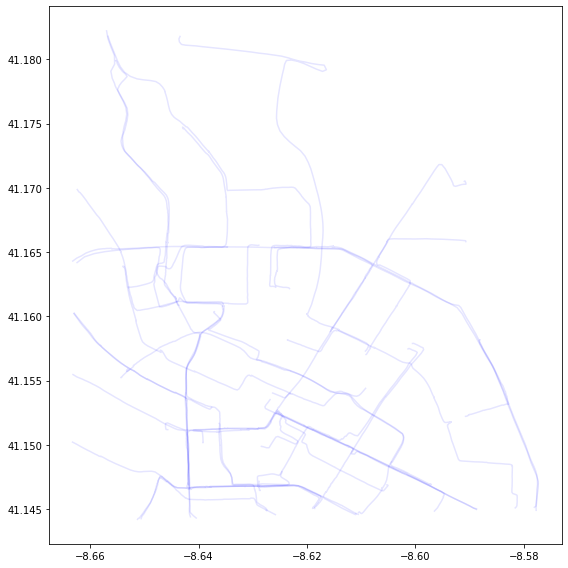

In [19]:
plt.figure(figsize=(8,8))
for i in range(len(Gen_traj)):
    traj=Gen_traj[i]
    plt.plot(traj[:,0],traj[:,1],color='blue',alpha=0.1)    # lng, lat
plt.tight_layout()
plt.savefig('Chengdu_traj.png')
plt.show()